STA 208 Project: CNNs and Bandwidth

Import libraries

In [1]:
from __future__ import print_function

#tesnsorflow
import tensorflow as tf

#keras
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model,Sequential
from keras.datasets import cifar10

#other
import time
import os


#plot
import matplotlib.pyplot as plt
import numpy as np

#sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#BW
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm


Using TensorFlow backend.


BW calculation

In [0]:
def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
  
def HuffmanBW(x_test):
    """ input: x_test
        output: average BW/image in Bytes
    """
    bitstream=0
    for imnum in range(0,x_test.shape[0]):
        img = x_test[imnum,]
        bitcount=0
        
        if(np.min(img) < 0):
            img = img - np.min(img)
        if(np.max(img)==0):
            img[0,0]=1
            
        txt = "".join(map(chr, img.flatten()))
        symb2freq = defaultdict(int)
        
        for ch in txt:
            symb2freq[ch] += 1
      
        huff = encode(symb2freq)
      ##### Calculating the number of bits needed
    
        for p in huff:
            bitcount = bitcount+  symb2freq[p[0]]*len(p[1])
        bitstream = bitstream + bitcount
    BW = np.round(bitstream/(x_test.shape[0]*8))            ## BW in bytes
    return BW

Resnet

In [0]:
def creategen(X,Y,batch_size):
    while True:
        # suffled indices    
        #idx = np.random.permutation( X.shape[0])
        # create image generator
        datagen = ImageDataGenerator(
                
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)

        batches= datagen.flow( X, Y, batch_size=batch_size,shuffle=True)
       
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]
            temp = batch[0].astype('float32')
            #waveletmy2.batchwaveletcdf97mat(batch[0].astype('float32'),M,16)
            #temp = waveletmy2.batchwaveletsArrange(temp)
            
            yield temp/np.max(np.abs(temp)) , batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-2
    elif epoch > 160:
        lr *= 1e-2
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr

n=1 #this is an indicator or depth (See keras Resnet implementation for CIFAR-10 for more details)
#the following are the n values of the models a,b,c,d,e,f
#a: n= 4
#b: n= 3
#c: n= 2
#d: n= 3
#e: n= 2
#f: n= 1

depth = n * 6 + 2 #model depth

# Model name, depth and version
model_type = 'ResNet%d' % (depth)

def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3, ######################### try to change this and see
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10,num_filters=16,pool_size=8):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = num_filters
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,num_filters = num_filters)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters  = int(num_filters*1.5)

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Tests in RGB

The most basic test for dimensionality reduction will be RGB. Three channels are used for pictures in CIFAR10 dataset consisting of 32 x 32 images.


In [0]:
#import
import numpy as np
from sklearn.decomposition import PCA
from keras.datasets import cifar10
from keras import layers
from keras import models
from keras.utils import to_categorical
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

For RGB Testing of accuracy and bandwidth, first designate function for a simple CNN with 32 hidden units (relu), Pooling (2,2), followed by a convolutional sequence of 64 units (reuli) and a flattening layer. Finally 64 more units (relu) and a softmax function to evaluate which of the  10 classes you predict. 

In [0]:
def Simple_CNN(train_images,train_labels,test_images,test_labels):
    
    train_images = train_images.astype('float32') / max_image

    test_images = test_images.astype('float32') / max_image
    
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    
    input_shape = train_images.shape[1:]
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)
    
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
    return test_loss, test_acc


In [7]:
#Code for NN
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

image_size = 32
channel_num = 3
max_image = 255

epochs = 200
batch_size = 50

rand_train = np.random.randint(0,train_images.shape[0],int(train_images.shape[0]*1/10))
train_images = train_images[rand_train,:]
train_labels = train_labels[rand_train]

rand_test = np.random.randint(0,test_images.shape[0],int(test_images.shape[0]*1/10))
test_images = test_images[rand_test,:]
test_labels = test_labels[rand_test]

#test_loss_CNN, test_acc_CNN = Simple_CNN(train_images,train_labels,test_images,test_labels)

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
#print(test_acc_CNN)

Doing the same as above but using ResNet 2.0

In [0]:
def ResCNN(train_images,train_labels,test_images,test_labels):
    
    train_images = train_images.astype('float32') / max_image

    test_images = test_images.astype('float32') / max_image
    
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    
    input_shape = train_images.shape[1:]
    depth = 8
    num_classes = 10
    
    model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes)
    
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

    callbacks = [lr_reducer, lr_scheduler]
    
    model.fit_generator(creategen(train_images, train_labels, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(train_images.shape[0]/32.0)),
                        epochs=epochs, verbose=1, workers=1,
                        callbacks=callbacks)    
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
    return test_loss, test_acc

In [0]:
test_loss_Resnet, test_acc_Resnet = ResCNN(train_images,train_labels,test_images,test_labels)

Instructions for updating:
Colocations handled automatically by placer.
Learning rate:  0.001
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
Learning rate:  0.001
157/157 [==============================] - 57s 362ms/step - loss: 1.9683 - acc: 0.2902
Epoch 2/200
Learning rate:  0.001


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


157/157 [==============================] - 55s 350ms/step - loss: 1.6851 - acc: 0.3929
Epoch 3/200
Learning rate:  0.001
157/157 [==============================] - 55s 348ms/step - loss: 1.5968 - acc: 0.4354
Epoch 4/200
Learning rate:  0.001
157/157 [==============================] - 55s 350ms/step - loss: 1.5154 - acc: 0.4652
Epoch 5/200
Learning rate:  0.001
157/157 [==============================] - 55s 348ms/step - loss: 1.4359 - acc: 0.5027
Epoch 6/200
Learning rate:  0.001
157/157 [==============================] - 55s 350ms/step - loss: 1.4031 - acc: 0.5090
Epoch 7/200
Learning rate:  0.001
157/157 [==============================] - 54s 347ms/step - loss: 1.3626 - acc: 0.5341
Epoch 8/200
Learning rate:  0.001
157/157 [==============================] - 55s 350ms/step - loss: 1.3087 - acc: 0.5433
Epoch 9/200
Learning rate:  0.001
157/157 [==============================] - 54s 347ms/step - loss: 1.2922 - acc: 0.5497
Epoch 10/200
Learning rate:  0.001
157/157 [======================

In [0]:
print(test_acc_Resnet)

NameError: ignored

Next proccess labels and images for PCA reduction.

In [0]:
#fit model with PCA

train_images_pca = train_images.reshape(train_images.shape[0],-1).astype('float32')
test_images_pca = test_images.reshape(test_images.shape[0],-1).astype('float32')

pca = PCA(0.99)
pca.fit_transform(train_images_pca)

train_images_pca_proj = pca.fit_transform(train_images_pca)
train_images_recon = pca.inverse_transform(train_images_pca_proj)

train_images_recon = train_images_recon.reshape(train_images.shape).astype('float32')

test_images_pca_proj = pca.fit_transform(test_images_pca)
test_images_recon = pca.inverse_transform(test_images_pca_proj)

test_images_recon = test_images_recon.reshape(test_images.shape).astype('float32')

In [0]:
#test_loss_CNN_PCA, test_acc_CNN_PCA = Simple_CNN(train_images_recon,train_labels,test_images_recon,test_labels)
test_loss_Resnet_PCA, test_acc_Resnet_PCA = ResCNN(train_images_recon,train_labels,test_images_recon,test_labels)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
157/157 [==============================] - 61s 386ms/step - loss: 1.9465 - acc: 0.3041
Epoch 2/200
Learning rate:  0.001


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


157/157 [==============================] - 58s 372ms/step - loss: 1.6586 - acc: 0.4139
Epoch 3/200
Learning rate:  0.001
157/157 [==============================] - 58s 372ms/step - loss: 1.5602 - acc: 0.4504
Epoch 4/200
Learning rate:  0.001
157/157 [==============================] - 58s 371ms/step - loss: 1.4998 - acc: 0.4746
Epoch 5/200
Learning rate:  0.001
157/157 [==============================] - 58s 373ms/step - loss: 1.4289 - acc: 0.4940
Epoch 6/200
Learning rate:  0.001
157/157 [==============================] - 59s 374ms/step - loss: 1.4014 - acc: 0.5118
Epoch 7/200
Learning rate:  0.001
157/157 [==============================] - 58s 372ms/step - loss: 1.3468 - acc: 0.5336
Epoch 8/200
Learning rate:  0.001
157/157 [==============================] - 59s 373ms/step - loss: 1.3061 - acc: 0.5460
Epoch 9/200
Learning rate:  0.001
157/157 [==============================] - 58s 371ms/step - loss: 1.2774 - acc: 0.5548
Epoch 10/200
Learning rate:  0.001
157/157 [======================

In [0]:
#print(test_acc_CNN_PCA)
print(test_acc_Resnet_PCA)

0.5924
0.442


Doing the bandwidth calculations,

In [0]:
BWtest = HuffmanBW(test_images)
BWtrain = HuffmanBW(train_images)
BWtest_PCA = HuffmanBW(test_images_pca_proj)
BWtrain_PCA = HuffmanBW(train_images_pca_proj)

In [0]:
print(BWtest)
print(BWtrain)
print(BWtest_PCA)
print(BWtrain_PCA)

2799.0
2800.0
578.0
603.0


In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
#convert to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#level offset
x_train = x_train - 128.0
x_test = x_test - 128.0

#flattening for PCA
x_train_ori = x_train.copy()
x_train_ori = x_train_ori.astype('float32')
x_test_ori = x_test.copy()
x_test_ori = x_test_ori.astype('float32')
x_train = x_train.reshape(x_train.shape[0],-1).astype('float32')
x_test = x_test.reshape(X_test.shape[0], -1).astype('float32')

input_shape = x_train_ori.shape[1:]

pca = PCA(0.99)
x_train_proj= pca.fit_transform(x_train)
x_train_proj = np.floor(x_train_proj/5)*5 #quantization

x_test_proj= pca.transform(x_test)
x_test_proj = np.floor(x_test_proj/5)*5

#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca.components_[i,:]/np.max(pca.components_[i,:]), (32,32,3)), cmap=plt.cm.bone, interpolation='nearest')

In [0]:
print(x_train_proj.shape)
print(x_train_ori.shape)
print(x_train_recon.shape)

(50000, 658)
(50000, 32, 32, 3)
(50000, 32, 32, 3)


In [0]:
x_train_recon = pca.inverse_transform(x_train_proj)
print(x_train_recon.shape)
x_train_recon = x_train_recon.reshape(x_train_ori.shape)
print(x_train_recon.shape)

x_test_recon = pca.inverse_transform(x_test_proj)
x_test_recon = x_test_recon.reshape(x_test_ori.shape)

print(x_train_ori.shape)

(50000, 3072)
(50000, 32, 32, 3)
(50000, 32, 32, 3)


Original images:


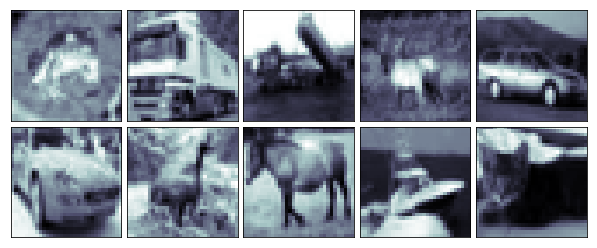

In [0]:
#show original images
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('Original images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_ori[i,:,:,0]/np.max(x_train_ori[i,:,:,0]), (32,32)), cmap=plt.cm.bone, interpolation='nearest')

reconstructed images:


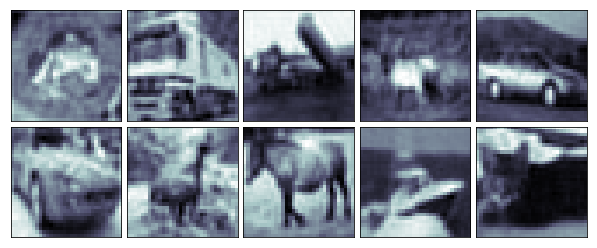

In [0]:
#recon images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('reconstructed images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_recon[i,:,:,0]/np.max(x_train_recon[i,:,:,0]), (32,32)), cmap=plt.cm.bone, interpolation='nearest')

# Tests in DCT

In [0]:
#fit model with PCA

train_images_pca = train_images.reshape(train_images.shape[0],-1).astype('float32')
test_images_pca = test_images.reshape(test_images.shape[0],-1).astype('float32')

pca = PCA(0.99)
pca.fit_transform(train_images_pca)

train_images_pca_proj = pca.fit_transform(train_images_pca)
train_images_recon = pca.inverse_transform(train_images_pca_proj)

train_images_recon = train_images_recon.reshape(train_images.shape).astype('float32')

test_images_pca_proj = pca.fit_transform(test_images_pca)
test_images_recon = pca.inverse_transform(test_images_pca_proj)

test_images_recon = test_images_recon.reshape(test_images.shape).astype('float32')

# Tests in DWT

In  DWT domain we primarily focus on 2 experiments.

## Experiment 1

Assume a cloud based image classification scenario. Here source device (mobile phone) sends an inference image over a bandlimited channel to the server to get the class label. Server receives the inference image and feeds it to a trained classifier to predict the class label. In order to conserve limited channel bandwidth and storage capacity, 
source devices often encode and compress the images before transmitting to the cloud by utilizing standardized
compression techniques such as JPEG2000.Because most neural networks are designed to classify images in the spatial RBG domain, the cloud currently receives and decodes the compressed j2k images back into the RGB domain before forwarding them to trained neural networks for further processing, as illustrated in the top part of the follwing figure. Thus, a natural question arises is to how to achieve faster training and inference with improved accuracy in a cloud based image classification under bandwidth, storage and computation constraints. 
	

<img src="files/figures/j2kcoder2.jpg">

We claim that the conventional use of image reconstruction is unnecessary for JPEG2000 encoded classification by constructing and training a deep CNN model with the DWT coefficients with CDF 9/7 wavelets. See the bottom part of the above figure. Furthermore, we establish that more accurate classification is also possible by deploying shallower models to benefit from faster training and classification in comparison to models trained fo spatial RGB image inputs. 

## result - 1

We trained a set of ResNet models for CIFAR-10 dataset and following figures compare the test accuracy and speed for training and inference process. 

<img src="files/figures/result12.JPG">

In the above figure, (a) illustrates test accuracy vs inference speed for the CIFAR-10 data set. The blue lines represent results using reconstructed RGB images. Red curve is the result using DWT coefficients with CDF 9/7 wavelets. (b) shows the Test error vs training speed/epoch. Here rate is the number of images that go through the model in each epoch.  The proposed model delivers fast and accurate classification for both training and inference. The points a,b,c,d,e and f correspond to 6 different ResNet models. The following table summerices these models.

<img src="files/figures/tabelresnet.JPG">

Following is the code for the above implementation.
1. Import the neccessary libraries 

2. We used the following ResNet model (reference - keras)

3. We used the following data augmentation method which gives flexibility to manipulate mini batches as necessary.

In [0]:
def creategen(X,Y,batch_size):
    while True:
        # suffled indices    
        #idx = np.random.permutation( X.shape[0])
        # create image generator
        datagen = ImageDataGenerator(
                
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)

        batches= datagen.flow( X, Y, batch_size=batch_size,shuffle=True)
       
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]
            yield  batch[0], batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

4. We used an initial learning rate of 0.001 which is reduced progressively at 80, 120 and 160 over 200 epochs.

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-2
    elif epoch > 160:
        lr *= 1e-2
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr

we used the following methods for preprocessing.

In [0]:
from numpy.linalg import inv

#RGB2YCbCr - RGB to YCbCr conversion
def batchRGB2YCRCB(x_batch):
    alpha_R = 0.299
    alpha_G = 0.587
    alpha_B = 0.114
    x_batchnew = np.zeros((x_batch.shape)).astype('float32')
    for i in range(0,x_batch.shape[0]):
        #Y
        x_batchnew[i,:,:,0] = alpha_R*x_batch[i,:,:,0] + alpha_G*x_batch[i,:,:,1] + alpha_B*x_batch[i,:,:,2]
        #Cb
        x_batchnew[i,:,:,1] = (0.5/(1-alpha_B))*(x_batch[i,:,:,2]-x_batchnew[i,:,:,0])
        #Cr
        x_batchnew[i,:,:,2] = (0.5/(1-alpha_R))*(x_batch[i,:,:,0]-x_batchnew[i,:,:,0])
    return x_batchnew


#generate the matrix for CDF 9/7 transform
def getTcdf97(height):
    a1 = -1.586134342
    a2 = -0.05298011854
    a3 = 0.8829110762
    a4 = 0.4435068522

    # Scale coeff:
    k1 = 0.8128662109 # 1/1.230174104914 // 0,2,4,6
    k2 = 0.6149902344 # 1.230174104914/2 // 5038 1,3,5,7
    X1 = np.identity(height)
    X2 = np.identity(height)
    X3 = np.identity(height)
    X4 = np.identity(height)
    X5 = np.zeros((height,height)).astype('float32')
    for col in range(1,height-2,2):
        X1[col-1,col]=X1[col+1,col]=a1
    X1[height-2,height-1] = 2*a1
    
    #print(X1)
    for col in range(2,height-1,2):
        X2[col-1,col]=X2[col+1,col]=a2
    X2[1,0] = 2*a2
    #print(X2)
    for col in range(1,height-2,2):
        X3[col-1,col]=X3[col+1,col]=a3
    X3[height-2,height-1] = 2*a3
    
    #print(X1)
    for col in range(2,height-1,2):
        X4[col-1,col]=X4[col+1,col]=a4
    X4[1,0] = 2*a4
    
    for col in range(0,height,1):
        if(col%2==0 ):
            #print(col)
            X5[col,int(col/2)]=k1
        else:
            X5[col,int(height/2 + (col-1)/2)]=k2
    #print(X3)
    X =np.matmul(np.matmul(np.matmul(np.matmul(X1,X2),X3),X4),X5)
    return X,inv(X)

#take Level 1 DWT
def batchwaveletcdf97mat(x_batch,X,dimhalf):
    x_batchnew = np.zeros((x_batch.shape[0],dimhalf,dimhalf,12)).astype('float32')
    for i in range(0,x_batch.shape[0]):
        for j in range(0,x_batch.shape[3]):
            coeff_array = np.matmul(np.matmul(X.transpose(),x_batch[i,:,:,j]),X)
            x_batchnew[i,:,:,j*4+0]=coeff_array[0:dimhalf,0:dimhalf]
            x_batchnew[i,:,:,j*4+1]=coeff_array[0:dimhalf,dimhalf:2*dimhalf]
            x_batchnew[i,:,:,j*4+2]=coeff_array[dimhalf:2*dimhalf,0:dimhalf]
            x_batchnew[i,:,:,j*4+3]=coeff_array[dimhalf:2*dimhalf,dimhalf:2*dimhalf]
    return x_batchnew

5. load the dataset and preprocessing.

In [0]:
# Load the CIFAR10 data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = 10
#convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


#level offset
X_train = X_train - 128.0
X_test = X_test - 128.0

#RGB2YCbCr - This converts RGB images to YCbCr format to facilitate compression - optional
X_train = batchRGB2YCRCB(X_train)
X_test = batchRGB2YCRCB(X_test)

#generate necessary matrices for DWT cdf9/7 trandformation
M,M_inv = getTcdf97(32)

#take level-1 DWT with CDF 9/7
x_train = batchwaveletcdf97mat(X_train.astype('float32'),M,16)
x_test = batchwaveletcdf97mat(X_test.astype('float32'),M,16)

### max normalization
x_train=x_train/np.max(np.abs(x_train))
x_test=x_test/np.max(np.abs(x_test))

input_shape = x_test.shape[1:]
print('input shape to resnet: ',input_shape)

input shape to resnet:  (16, 16, 12)


6. convert labels to one hot encoding

In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

7. compile the model: we used Adam optimizer.

In [0]:
batch_size = 32  
epochs = 1

model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes,num_filters=64,pool_size=4)

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.summary()
print(model_type)

8. Set callback methods

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

9. Train the model - We used a server with Titan-V GPU. (We train only for 1 epoch to show the code works. We used 200 epochs to train both RGB and  DWT and models)

In [0]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(creategen(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0]/32.0)),
                        epochs=epochs, verbose=1, workers=1,
                        callbacks=callbacks)

Epoch 1/1


c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (50000, 16, 16, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Learning rate:  0.001
1563/1563 [==============================] - 48s 31ms/step - loss: 1.6007 - acc: 0.4849


c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\keras\callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


10. Evaluate the test set - The results below is after 1 eopoch.(to show the code works)

In [0]:
start = time.time()
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('time per image :',(time.time()-start)*1000/10000,' ms')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 279us/step
time per image : 0.27921199798583984  ms
Test loss: 1.5340371086120606
Test accuracy: 0.5315


# Experiment 2

In this experiment we start with Level 1 DWT coefficents with CDF 9/7 wavelet and explre methods to reduce the required bandwidth () 
in cloud based image classification. To create a baseline, we train a ResNet-8 with quantized CDF 9/7 DWT coefficients BW
and measure the classification accuracy of CIFAR-10 dataset (say $a_1$) and calculate the BW with Huffman encoding. (Say $BW_1$). Then we perform a principal component analysis (PCA) on the vectorized dataset to reduce the dimentionality of data with the perpose of reducing bandwidth. We can calculate the average BW of these quantized PCA projections (say $BW_2$). Then we reconstruct the wavelet coefficients to the original dimension and train a ResNet-8 to obtain $a_2$ accuracy. We observed that $BW_2$ is much smaller than $BW_1$ and $a_1$ and $a_2$ are considerably close.

This observation implies than we can save bandwidth by only sending the projected DWT coefficients rather than sending the complete image
with a negligible accuracy loss. We can apply this in to practice like this. We can do a PAC analysis on a large dataset like
ImageNet and store the principal components at the server. Source device can calculate the projections and transmit these projections
consuming smaller BW. At the server end, high dimentional image can be reconstructed using the stored PCA coefficients and feed to 
a classifier.

We obtained the following results.

| Method | Test Accuracy (%) | Bandwidth (Bytes) |
| --- | --- | --- |
| Original DWT quantized | 90 | 1552 |
| PCA DWT quantized | 90 | 317 |

Following is the code for the implementation.
Let's load the data set and calculate PCA components

In [0]:
#import libraries

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score




We used the following Huffman encoder to calculate the required BW

In [0]:
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm


Load CIFAR-10, tahe DWT and flatten the data for PCA

In [0]:
# Load the CIFAR10 data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = 10
#convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


#level offset
X_train = X_train - 128.0
X_test = X_test - 128.0

#RGB2YCbCr - This converts RGB images to YCbCr format to facilitate compression - optional
X_train = batchRGB2YCRCB(X_train)
X_test = batchRGB2YCRCB(X_test)

#generate necessary matrices for DWT cdf9/7 trandformation
M,M_inv = getTcdf97(32)

#take level-1 DWT with CDF 9/7
x_train = batchwaveletcdf97mat(X_train.astype('float32'),M,16)
x_test = batchwaveletcdf97mat(X_test.astype('float32'),M,16)

#flattening for PCA
x_train_ori = x_train.copy()
x_train_ori = x_train_ori.astype('float32')
x_test_ori = x_test.copy()
x_test_ori = x_test_ori.astype('float32')
x_train = x_train.reshape(x_train.shape[0],-1).astype('float32')
x_test = x_test.reshape(X_test.shape[0], -1).astype('float32')

input_shape = x_train_ori.shape[1:]
print(x_train.shape)
print('input shape to resnet: ',input_shape)
print('Dataset shape after vectorizing: ',x_train.shape)

(50000, 3072)
input shape to resnet:  (16, 16, 12)
Dataset shape after vectorizing:  (50000, 3072)


Calculate PCA and choose the components to preserve 99% of the variance 

In [0]:
pca = PCA(0.99)
x_train_proj= pca.fit_transform(x_train)
x_train_proj = np.floor(x_train_proj/5)*5 #quantization

x_test_proj= pca.transform(x_test)
x_test_proj = np.floor(x_test_proj/5)*5


print('original representation',x_train.shape)
print('reduced representation: ',x_train_proj.shape)

original representation (50000, 3072)
reduced representation:  (50000, 687)


With PCA we reduced the feature size from 3072 to 687. Let's display the first few principal compenents.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

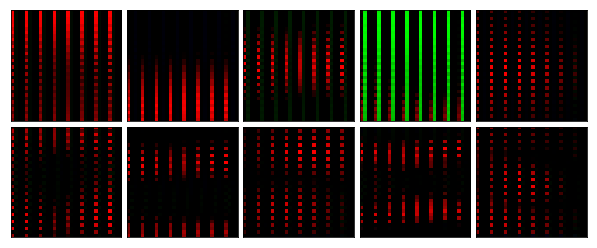

In [0]:
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca.components_[i,:]/np.max(pca.components_[i,:]), (32,32,3)), cmap=plt.cm.bone, interpolation='nearest')

Now recontruct the images after dim reduction.For the display purposes we only show the 1st subband of 12 subbands of the images.

(50000, 687)
(50000, 3072)
(50000, 16, 16, 12)
Original images:
reconstructed images:


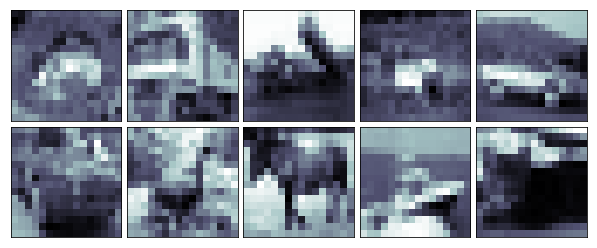

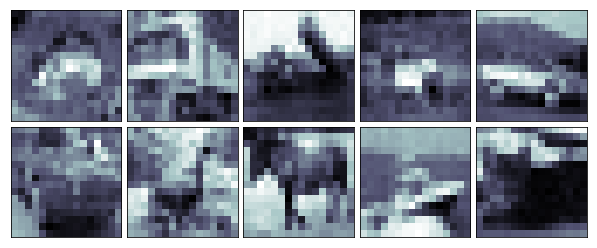

In [0]:
print(x_train_proj.shape)
x_train_recon = pca.inverse_transform(x_train_proj)
print(x_train_recon.shape)
x_train_recon = x_train_recon.reshape(x_train_ori.shape)
print(x_train_recon.shape)

x_test_recon = pca.inverse_transform(x_test_proj)
x_test_recon = x_test_recon.reshape(x_test_ori.shape)

#show original images
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('Original images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_ori[i,:,:,0]/np.max(x_train_ori[i,:,:,0]), (16,16)), cmap=plt.cm.bone, interpolation='nearest')
  
#recon images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('reconstructed images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_recon[i,:,:,0]/np.max(x_train_recon[i,:,:,0]), (16,16)), cmap=plt.cm.bone, interpolation='nearest')
  

Origianal and reconstructured images look similar. Now we can calculate $BW_1$ and $BW_2$.

$BW_1$

In [0]:
BWr = HuffmanBW(np.floor(x_train_ori).astype('int32'))
print('original images avg.BW/image: ',str(BWr),' Bytes')

original images avg.BW/image:  1552.0  Bytes


$BW_2$

In [0]:
BWp = HuffmanBW(x_train_proj.astype('int32'))
print('projections avg.BW/image: ',str(BWp),' Bytes')

projections avg.BW/image:  317.0  Bytes


Now lets train the network to obtain $a_2$.

In [0]:
### max normalization
x_train=x_train_recon/np.max(np.abs(x_train_recon))
x_test=x_test_recon/np.max(np.abs(x_test_recon))

input_shape = x_test.shape[1:]
print('input shape to resnet: ',input_shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

input shape to resnet:  (16, 16, 12)


Complile the ResNet-8 model

In [0]:
batch_size = 32  
epochs = 1

model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes)

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16, 16, 12)   0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 16, 16, 64)   6976        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 16, 16, 64)   256         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 16, 16, 64)   0           batch_normalization_22[0][0]     
_______________________________________________________________________________________

Set call backs and fit. (We train only for 1 epoch to show the code works. We used a Titan_V GPU with 200 epochs to train both original DWT and PCA models)

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(creategen(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0]/32.0)),
                        epochs=epochs, verbose=0, workers=1,
                        callbacks=callbacks)

c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (50000, 16, 16, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Learning rate:  0.001


c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\keras\callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Evaluate the testSet after 1 epoch.

In [0]:
start = time.time()
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=0)
print('time per image :',(time.time()-start)*1000/10000,' ms')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

time per image : 0.2656890869140625  ms
Test loss: 1.3354834184646607
Test accuracy: 0.5856


# Tests in DWT